In [1]:
!pip install streamlit

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import shap
import umap.umap_ as umap
import xgboost as xgb
import streamlit as st


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
df = pd.read_csv("/content/blood.csv")

In [4]:
print(df.head())

   Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0


In [5]:
print(df.describe())

          Recency   Frequency      Monetary        Time       Class
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.516043   1378.676471   34.284759    0.237968
std      8.095396    5.841825   1459.826781   24.380307    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max     74.000000   50.000000  12500.000000   99.000000    1.000000


In [6]:
df.shape

(748, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [8]:
df.index

RangeIndex(start=0, stop=748, step=1)

In [59]:
# Compute correlation matrix
corr = df.corr()

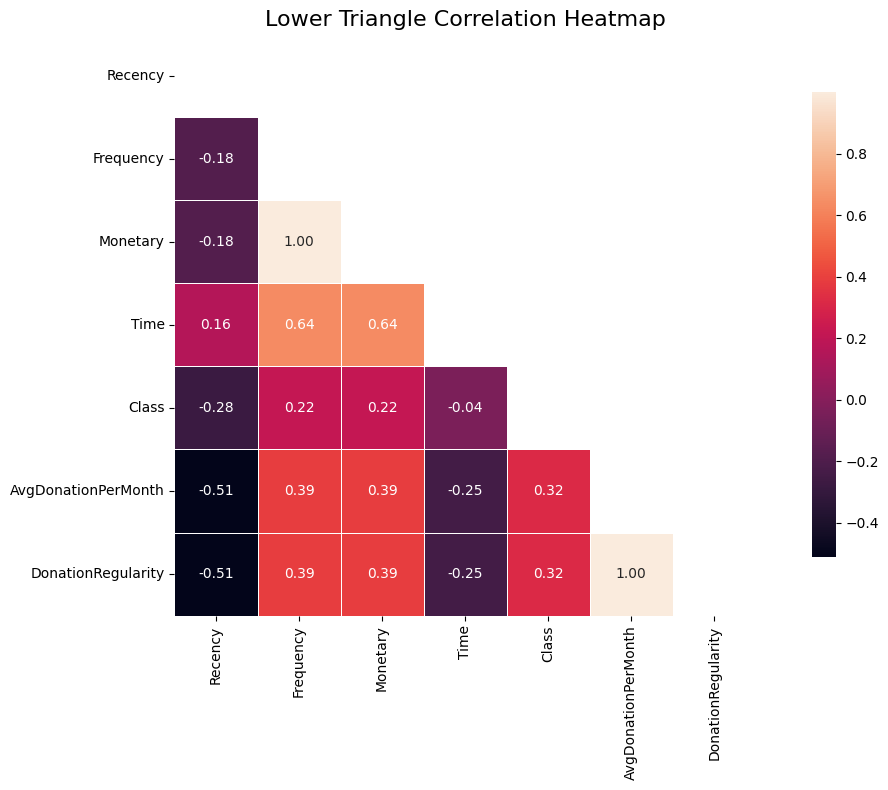

In [62]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr,
            mask=mask,
            annot=True,
            cmap="rocket",  # Red to black color palette
            fmt=".2f",
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8})
plt.title("Lower Triangle Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


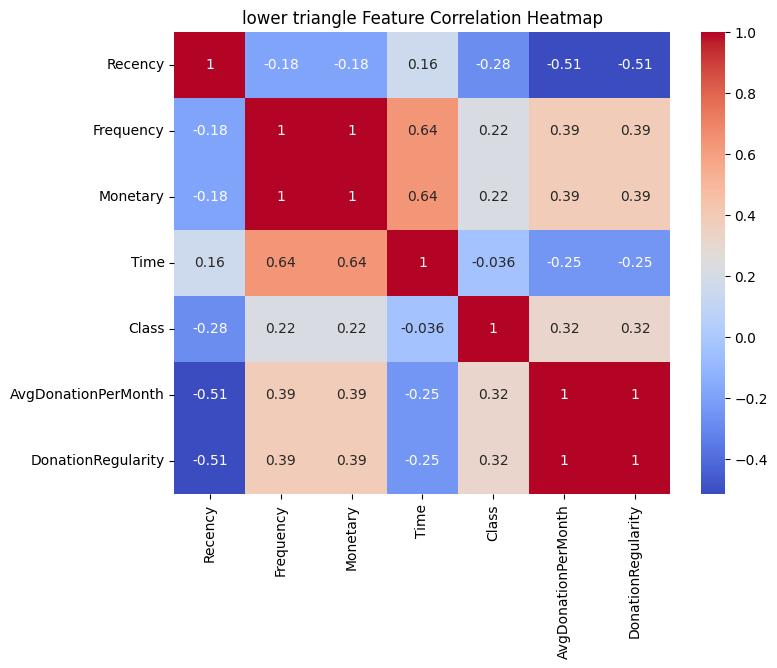

In [58]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

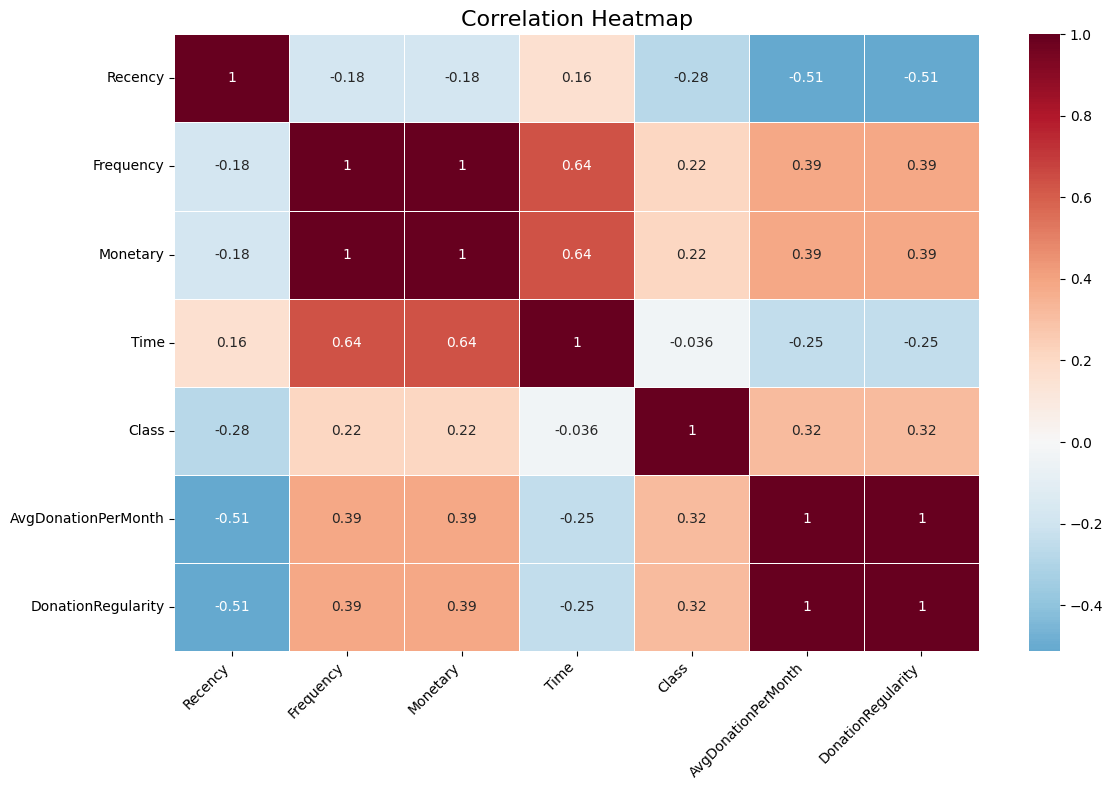

In [61]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, linewidths=0.5, linecolor='white')
plt.xticks(rotation=45, ha='right')
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


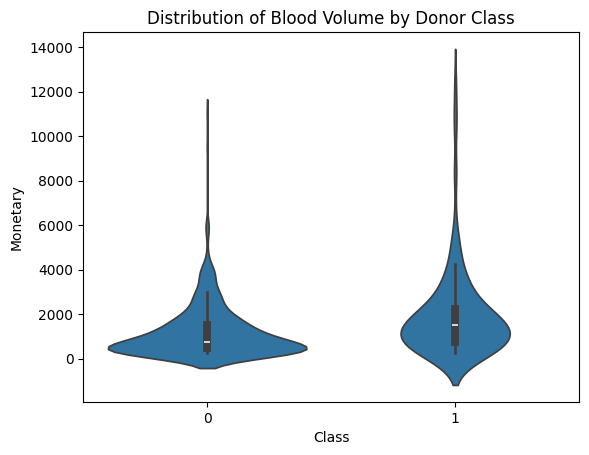

In [14]:
# Violin Plot for Monetary vs Class
sns.violinplot(x='Class', y='Monetary', data=df)
plt.title("Distribution of Blood Volume by Donor Class")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


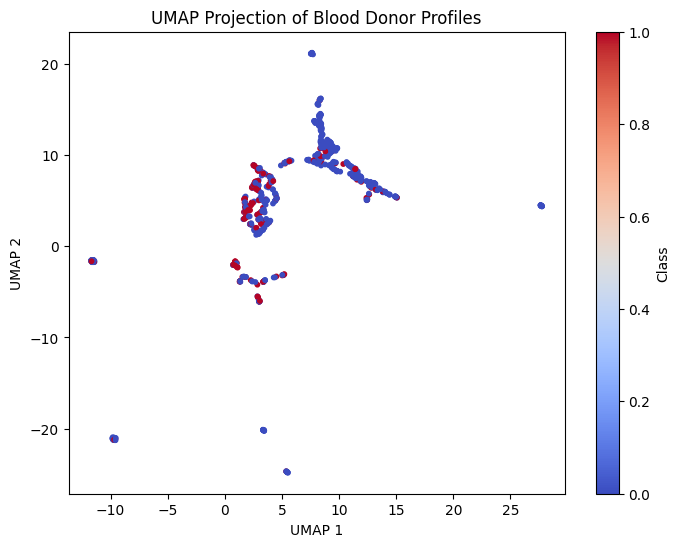

In [15]:
# UMAP Projection
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('Class', axis=1))
embedding = umap.UMAP().fit_transform(df_scaled)

plt.figure(figsize=(8,6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Class'], cmap='coolwarm', s=10)
plt.title("UMAP Projection of Blood Donor Profiles")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Class')
plt.show()

In [16]:
df['AvgDonationPerMonth'] = df['Monetary'] / (df['Time'] + 1)
df['DonationRegularity'] = df['Frequency'] / (df['Time'] + 1)


In [17]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_test


In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


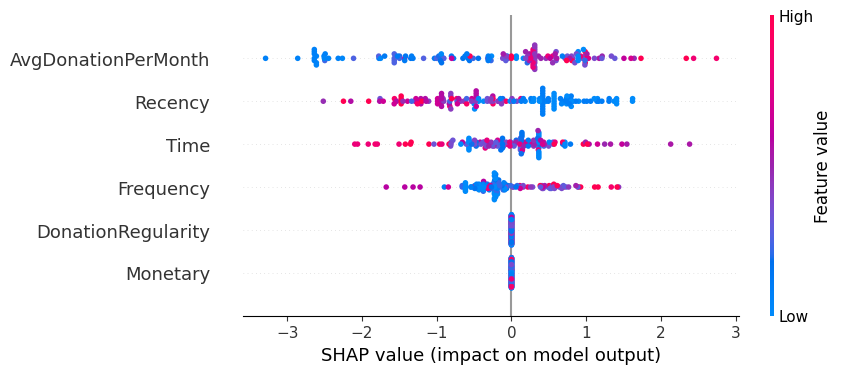

In [49]:
# Train an XGBoost model
# Use the scaled data for training
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss') # Added parameters for clarity and to avoid warnings
model.fit(X_train_scaled, y_train) # Fit on scaled data

# Use the scaled training data for the explainer
explainer = shap.Explainer(model, X_train_scaled, feature_names=X.columns.tolist()) # Pass feature names here
shap_values = explainer(X_test_scaled)
shap.plots.beeswarm(shap_values)

In [50]:
def generate_recommendation(model, scaler, patient_data):
    patient_scaled = scaler.transform(patient_data)
    prediction = model.predict(patient_scaled)[0]
    recommendation = {
        0: "Low risk: Maintain current lifestyle.",
        1: "High risk: Increase exercise and improve diet; consult a healthcare provider."
    }
    return recommendation[prediction]


In [51]:
def main():
    st.title("Personalized Healthcare Recommendation System")

    # Generate and process data
    df = generate_synthetic_data()
    df = engineer_features(df)
    X_scaled, y, feature_names, scaler = preprocess_data(df)


In [21]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       113
           1       0.48      0.30      0.37        37

    accuracy                           0.75       150
   macro avg       0.64      0.60      0.60       150
weighted avg       0.72      0.75      0.72       150



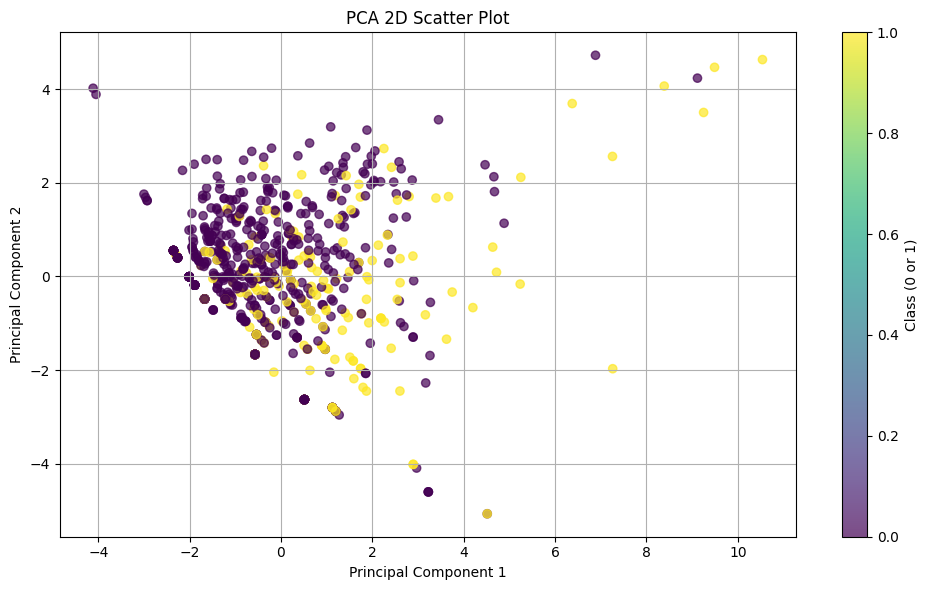

In [55]:
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
# Ensure the column name matches the target variable name
pca_df['Class'] = y

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['Principal Component 1'],
    pca_df['Principal Component 2'],
    # Use the correct column name for coloring
    c=pca_df['Class'],
    cmap='viridis',
    alpha=0.7
)

# Add color bar
cbar = plt.colorbar(scatter)
# Update color bar label to reflect the correct target variable
cbar.set_label('Class (0 or 1)')

# Labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA 2D Scatter Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

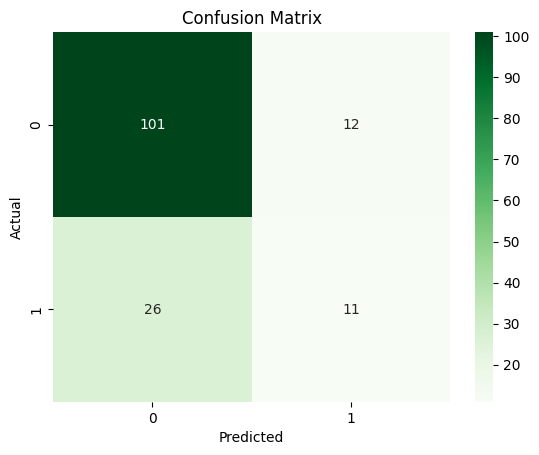

In [22]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


<ipython-input-23-18320220>:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test.iloc[:100], feature_names=X.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

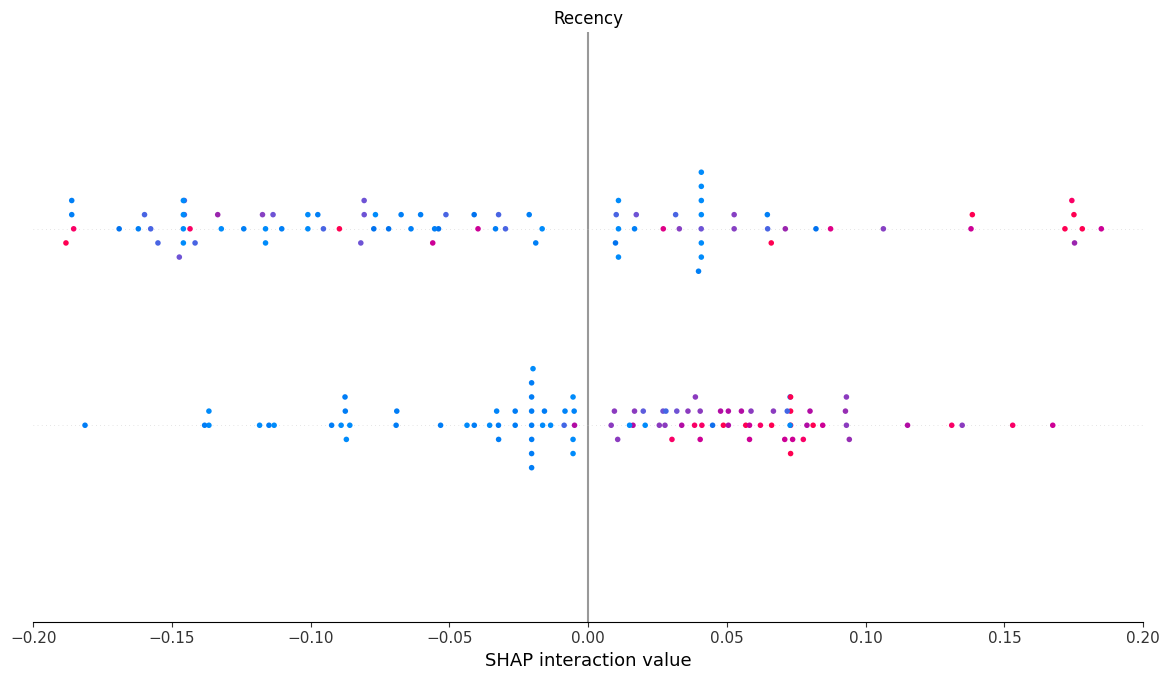

In [23]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100], check_additivity=False)

# The features for the summary plot should correspond to the unscaled test set for readability
shap.summary_plot(shap_values, features=X_test.iloc[:100], feature_names=X.columns)

In [52]:
def recommend_action(row):
    if row['DonationRegularity'] < 0.05:
        return "Encourage regular checkups and follow-up."
    elif row['AvgDonationPerMonth'] > 400:
        return "Eligible for recognition or long-term donor program."
    elif row['Recency'] > 6:
        return "Send reminder to donate again."
    else:
        return "Healthy donation pattern."

X_test_sample = X_test.copy()
X_test_sample['Recommendation'] = X_test_sample.apply(recommend_action, axis=1)
print("\nSample Recommendations:\n")
print(X_test_sample[['Recency', 'Frequency', 'Monetary', 'Time', 'Recommendation']].head())


Sample Recommendations:

     Recency  Frequency  Monetary  Time                  Recommendation
580        2          1       250     2       Healthy donation pattern.
356       16          6      1500    40  Send reminder to donate again.
133        4          6      1500    35       Healthy donation pattern.
250       11          2       500    11  Send reminder to donate again.
299       14          2       500    14  Send reminder to donate again.


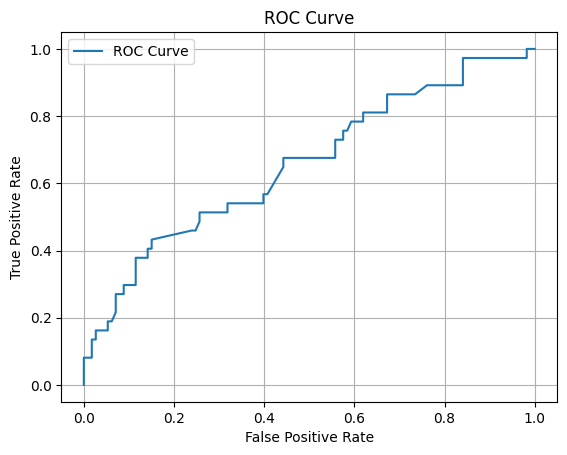

In [47]:
probs = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()



In [26]:
print("\nAUC Score:", roc_auc_score(y_test, probs))



AUC Score: 0.6735230806027266
